## Visualization
One of the benefits of the attention mechanism is that it can be quite intuitive, particularly when the weights are nonnegative and sum to 
. In this case we might interpret large weights as a way for the model to select components of relevance. While this is a good intuition, it is important to remember that it is just that, an intuition. Regardless, we may want to visualize its effect on the given set of keys, when applying a variety of different queries. This function will come in handy later.

We thus define the show_heatmaps function. Note that it does not take a matrix (of attention weights) as its input but rather a tensor with 4 axes, allowing for an array of different queries and weights. Consequently the input matrices has the shape (number of rows for display, number of columns for display, number of queries, number of keys). This will come in handy later on when we want to visualize the workings that is used to design Transformers.

In [1]:
import torch
from d2l import torch as d2l

In [2]:
# @save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)


In [ ]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')


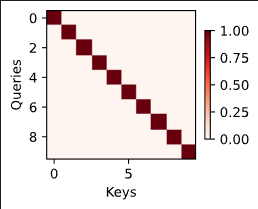